<a href="https://colab.research.google.com/github/corentin-pujol/q-Obesity-types-prediction/blob/main/Obesity_levels_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Projet de Quentin PELET & Corentin PUJOL

Import of the different libraries that we will use for data visualisation, analysis and prediction:



In [500]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

Transformation of the csv file into a dataframe and deletion of lines containing Nan values:

In [501]:
url = "/content/ObesityDataSet_raw_and_data_sinthetic.csv"
df = pd.read_csv(url)
df_copie = pd.read_csv(url)
df.dropna(inplace=True)
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


Changed the names of some columns to have a better visibility of their meaning and displayed a consistent description of the different information in the dataframe.

In [502]:
col_names = ["Gender", "Age", "Height", "Weight", "Family_overweight", "FAVC", "FCVC", "NCP", "CAEC", "Smoke", "CH2O", "SCC", "FAF", "TUE", "CALC", "Transportation", "Obesity_level_category"]
df.columns = col_names

Columns names description :

FAVC -> Frequent consumption of high caloric food 

FCVC -> Frequency of consumption of vegetables

NCP -> Number of main daily meals

CAEC -> Consumption of food between meals

CH2O -> Consumption of water daily

SCC -> Does the person count how many calories he consums daily

FAF -> Physical usual activity 

TUE -> How many times the person spends on a screen daily

CALC -> Usual alcohol consumption




Now, we are going to tranform all the qualitative variables as quantitative variables (Gender, Family overweight, FAVC, CAEC, Smoke, SCC, CALC, Transportation, Obesity level category)

Age : We truncate the values to the unit

And for the other variables, we decided to round the values because we thought that it didn't make sense to have six or seven numbers after the comma.

In [503]:
df["Gender"] = df["Gender"].apply(lambda x : 1 if x=="Female" else 0)
df["Age"] = df["Age"].apply(lambda x : int(float(int(x*100))/100))
df["Height"] = df["Height"].apply(lambda x : round(x,2))
df["Weight"] = df["Weight"].apply(lambda x : round(x,1))
df["Family_overweight"] = df["Family_overweight"].apply(lambda x : 1 if x=="yes" else 0)
df["FAVC"] = df["FAVC"].apply(lambda x : 1 if x=="yes" else 0)
df["FCVC"] = df["FCVC"].apply(lambda x : int(round(x,0)))
df["NCP"] = df["NCP"].apply(lambda x : int(round(x,0)))
df["CAEC"], unique_CAEC = pd.factorize(df["CAEC"], sort=True)
df["Smoke"] = df["Smoke"].apply(lambda x : 1 if x=="yes" else 0)
df["CH2O"] = df["CH2O"].apply(lambda x : round(x,0))
df["SCC"] = df["SCC"].apply(lambda x : 1 if x=="yes" else 0)
df["FAF"] = df["FAF"].apply(lambda x : int(round(x,0)))
df["TUE"] = df["TUE"].apply(lambda x : round(x,0))
df["CALC"], unique_CALC = pd.factorize(df["CALC"], sort=True)
# df["Transportation"], unique_Transportation = pd.factorize(df["Transportation"], sort=True)

transportation ={"Automobile": 1, "Bike": 2, "Motorbike": 3, "Public_Transportation": 4, "Walking": 5}

df["Transportation"] = df["Transportation"].map(transportation,na_action='ignore').apply(lambda x : int(x))

df

,Gender,Age,Height,Weight,Family_overweight,FAVC,FCVC,NCP,CAEC,Smoke,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,64.0,1,0,2,3,2,0,2.0,0,0,1.0,3,4,Normal_Weight
1,1,21,1.52,56.0,1,0,3,3,2,1,3.0,1,3,0.0,2,4,Normal_Weight
2,0,23,1.80,77.0,1,0,2,3,2,0,2.0,0,2,1.0,1,4,Normal_Weight
3,0,27,1.80,87.0,0,0,3,3,2,0,2.0,0,2,0.0,1,5,Overweight_Level_I
4,0,22,1.78,89.8,0,0,2,1,2,0,2.0,0,0,0.0,2,4,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,131.4,1,1,3,3,2,0,2.0,0,2,1.0,2,4,Obesity_Type_III
2107,1,21,1.75,133.7,1,1,3,3,2,0,2.0,0,1,1.0,2,4,Obesity_Type_III
2108,1,22,1.75,133.7,1,1,3,3,2,0,2.0,0,1,1.0,2,4,Obesity_Type_III
2109,1,24,1.74,133.3,1,1,3,3,2,0,3.0,0,1,1.0,2,4,Obesity_Type_III


Transformation of the quantitative types of obesity level categories into numerical values, in order to study the correlation matrix, in the next part.

In [504]:
obesity_level ={"Insufficient_Weight": 0, "Normal_Weight": 1, "Overweight_Level_I": 2, "Overweight_Level_II": 3, "Obesity_Type_I": 4, "Obesity_Type_II": 5, "Obesity_Type_III": 6}

df["Obesity_level_category"] = df["Obesity_level_category"].map(obesity_level,na_action='ignore').apply(lambda x : int(x))

df

,Gender,Age,Height,Weight,Family_overweight,FAVC,FCVC,NCP,CAEC,Smoke,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,64.0,1,0,2,3,2,0,2.0,0,0,1.0,3,4,1
1,1,21,1.52,56.0,1,0,3,3,2,1,3.0,1,3,0.0,2,4,1
2,0,23,1.80,77.0,1,0,2,3,2,0,2.0,0,2,1.0,1,4,1
3,0,27,1.80,87.0,0,0,3,3,2,0,2.0,0,2,0.0,1,5,2
4,0,22,1.78,89.8,0,0,2,1,2,0,2.0,0,0,0.0,2,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,131.4,1,1,3,3,2,0,2.0,0,2,1.0,2,4,6
2107,1,21,1.75,133.7,1,1,3,3,2,0,2.0,0,1,1.0,2,4,6
2108,1,22,1.75,133.7,1,1,3,3,2,0,2.0,0,1,1.0,2,4,6
2109,1,24,1.74,133.3,1,1,3,3,2,0,3.0,0,1,1.0,2,4,6


#Visualization of the data and correlation

The correlation matrix of the different variables in the dataset is plotted below in order to visualise which variables are more or less correlated with the obesity level category.

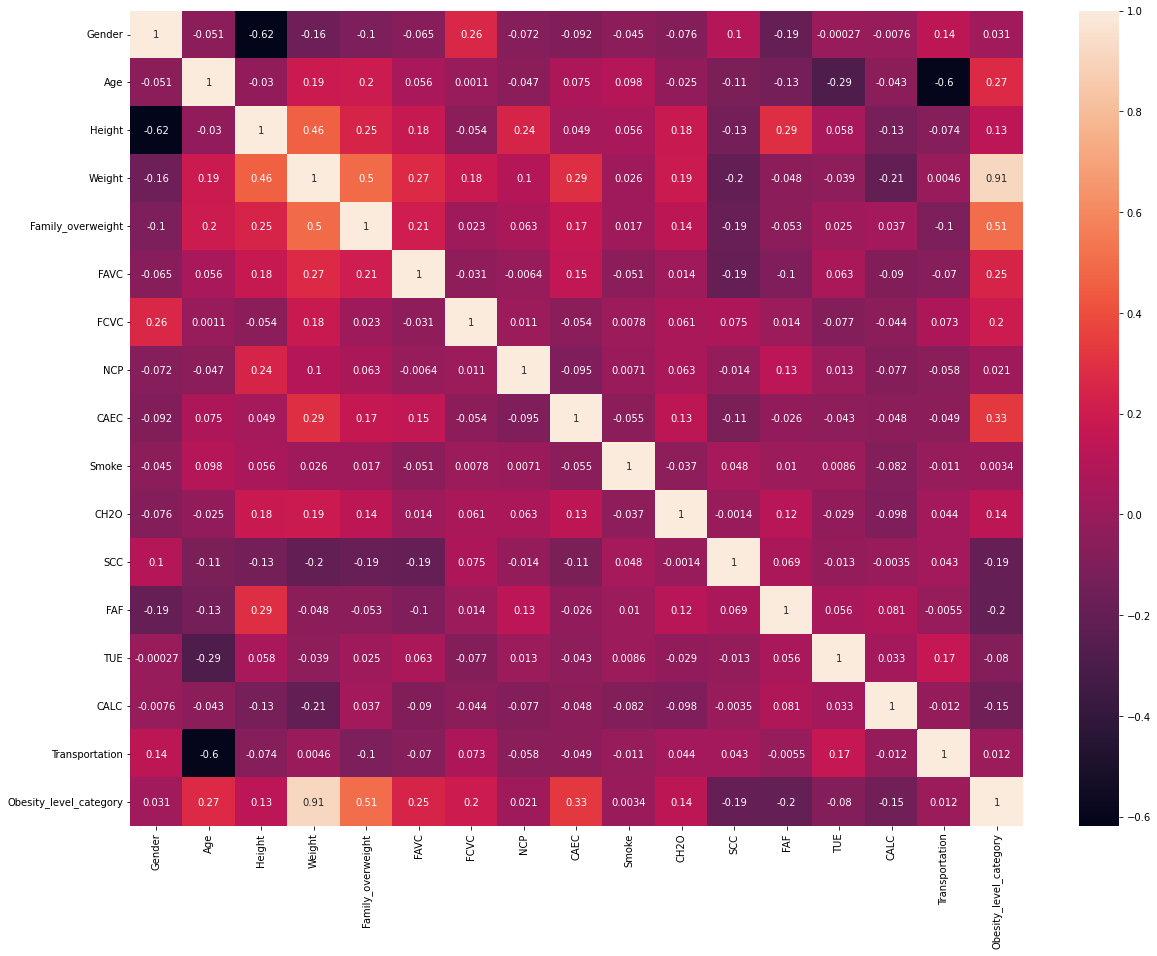

In [505]:
corr_df = df.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr_df, annot=True)
plt.show()

We notice that the variable Weight is highly correlated with the level of obesity, which is logical since weight is very determinant in determining the level of obesity with the BMI.

We also notice that some variables have very little influence on the level of obesity, which is the case for example with the variables Smoke, Gender, NCP, or even the variable Transportation.

Let us now study the distribution of the data in more details to determine whether certain columns are biased with respect to the representation of a normal population. Indeed, if we wish to set up a generalizable study and prediction model, we must work on a sample that is as representative as possible of the reality.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f15af430310>,
      dtype=object)

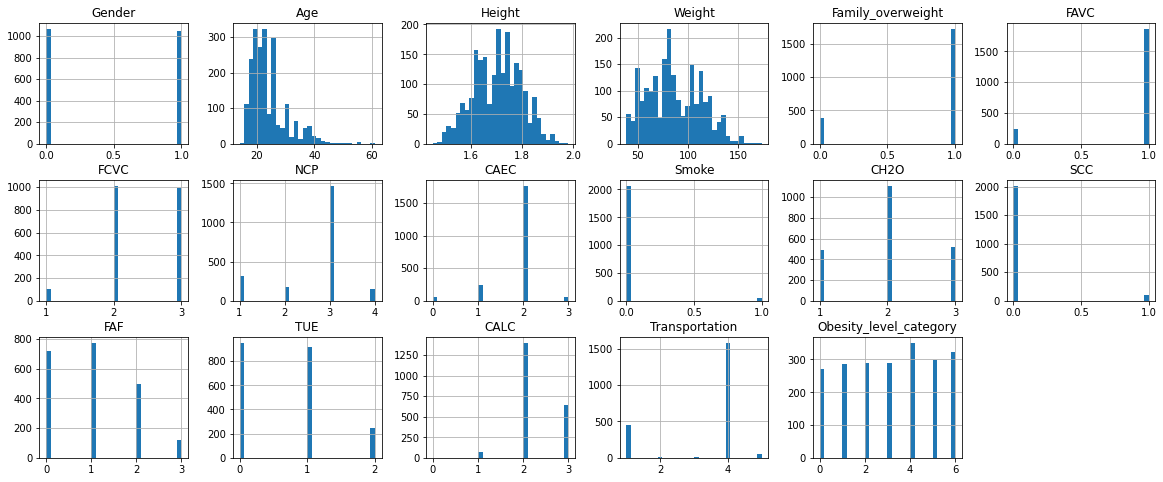

In [506]:
df[col_names].hist(bins=30, figsize=(20, 8), layout=(3, 6))

Although the age curve shows us that the sample is quite young, we see that there are as many men and women of different heights and weights. The sample is well representative of a real population.

Moreover, there is a homogeneous distribution of the different categories of obesity.

However, we can notice something quite surprising in the "Smoke" variable:

In [507]:
df.groupby("Smoke").count()["Gender"]

Smoke
0    2067
1      44
Name: Gender, dtype: int64

We can see that 2% of our sample is a smoker, which is not representative of the number of people who smoke in South America. For example, 16% of the adult population smokes in Mexico, which is considerably more. 

Because there are not enough smokers in the sample, we doubt its true impact on obesity in this study, and we decide to remove the variable from the dataset.

In [508]:
df.drop(['Smoke'],axis = 1, inplace = True)

Nous pouvons aussi observer plus haut une répartition assez inégale au niveau des moyens de transport. 

In [509]:
df_copie.groupby("MTRANS").count()["Gender"]

MTRANS
Automobile                457
Bike                        7
Motorbike                  11
Public_Transportation    1580
Walking                    56
Name: Gender, dtype: int64

We can see that this variable tells us whether an individual uses a means of transport that requires physical effort (walking or cycling) or not (car, bus or motorbike). In order for this variable to have a greater impact on the prediction of obesity levels, by having a distinct boundary, we have chosen to transform the column by grouping together means of transport requiring physical effort and those not requiring any.

Thus, cars, motorbikes and public transport (categories 1, 3 and 4) will be categorised as 0 as they produce no physical effort, while walking and cycling (categories 2 and 5) will be categorised as 1.

In [510]:
df['Transportation']=np.where(df['Transportation']==1,0,df['Transportation']) #Automobile
df['Transportation']=np.where(df['Transportation']==3,0,df['Transportation']) #Motorbike
df['Transportation']=np.where(df['Transportation']==4,0,df['Transportation']) #Public transportation

df['Transportation']=np.where(df['Transportation']==2,1,df['Transportation']) #Bike
df['Transportation']=np.where(df['Transportation']==5,1,df['Transportation']) #Walking

# df.groupby(by=df['Transportation']).count()['Gender']

We are going now, to plot different pairwise relationships in this dataset, in order to see if there are other interesting things to take into account.

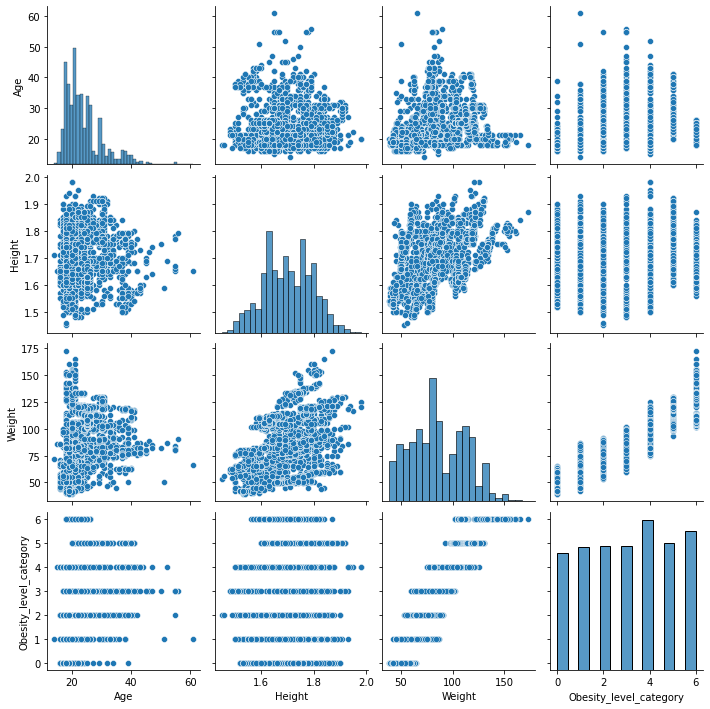

In [511]:
sns.pairplot(df[["Age","Height","Weight","Obesity_level_category"]])

It can be seen that as a person's weight increases, so does their level of obesity. 
Furthermore, height does not influence the level of obesity

This confirms that the BMI, to determine the level of obesity, is calculated from the weight of a person

To allow the models to take more account of the other variables, we have decided to remove the Weight variable from the dataframe. We will still try different models with it in place for comparison purposes.

**PS: compare the accuracy of models with and without Weight**

In [512]:
df.drop(['Weight'],axis = 1, inplace = True)

# Model prediction

x:variables de predictions
y:target variable

In [513]:
# x=df.loc[:,df.columns!="Obesity_level_category"]
# y=df.loc[:,df.columns=="Obesity_level_category"]

Scale des données

In [514]:
# scaler=StandardScaler()
# scaler.fit(x)
# x_scaled=scaler.transform(x)

Split en train_set et en test_set

In [515]:
# x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [516]:
# print(x_train.shape)
# print(x_test.shape)
# print(y_train.shape)
# print(y_test.shape)

1. KNN
2. SVM
3. Boosting
4. Random Forest
5. Logistic Regression 
6. LDA/QDA




#Linear Discriminant Analysis

##All classes

In [517]:
df = pd.read_csv(url)
df.dropna(inplace=True)

col_names = ["Gender", "Age", "Height", "Weight", "Family_overweight", "FAVC", "FCVC", "NCP", "CAEC", "Smoke", "CH2O", "SCC", "FAF", "TUE", "CALC", "Transportation", "Obesity_level_category"]
df.columns = col_names

df["Gender"] = df["Gender"].apply(lambda x : 1 if x=="Female" else 0)
df["Age"] = df["Age"].apply(lambda x : int(float(int(x*100))/100))
df["Height"] = df["Height"].apply(lambda x : round(x,2))
df["Weight"] = df["Weight"].apply(lambda x : round(x,1))
df["Family_overweight"] = df["Family_overweight"].apply(lambda x : 1 if x=="yes" else 0)
df["FAVC"] = df["FAVC"].apply(lambda x : 1 if x=="yes" else 0)
df["FCVC"] = df["FCVC"].apply(lambda x : int(round(x,0)))
df["NCP"] = df["NCP"].apply(lambda x : int(round(x,0)))
df["CAEC"], unique_CAEC = pd.factorize(df["CAEC"], sort=True)
df["Smoke"] = df["Smoke"].apply(lambda x : 1 if x=="yes" else 0)
df["CH2O"] = df["CH2O"].apply(lambda x : round(x,1))
df["SCC"] = df["SCC"].apply(lambda x : 1 if x=="yes" else 0)
df["FAF"] = df["FAF"].apply(lambda x : int(round(x,0)))
df["TUE"] = df["TUE"].apply(lambda x : round(x,2))
df["CALC"], unique_CALC = pd.factorize(df["CALC"], sort=True)

transportation ={"Automobile": 1, "Bike": 2, "Motorbike": 3, "Public_Transportation": 4, "Walking": 5}

df["Transportation"] = df["Transportation"].map(transportation,na_action='ignore').apply(lambda x : int(x))

df['Transportation']=np.where(df['Transportation']==1,0,df['Transportation']) #Automobile
df['Transportation']=np.where(df['Transportation']==3,0,df['Transportation']) #Motorbike
df['Transportation']=np.where(df['Transportation']==4,0,df['Transportation']) #Public transportation

df['Transportation']=np.where(df['Transportation']==2,1,df['Transportation']) #Bike
df['Transportation']=np.where(df['Transportation']==5,1,df['Transportation']) #Walking

df.drop(['Weight'],axis = 1, inplace = True)
df.drop(['Smoke'],axis = 1, inplace = True)

df

,Gender,Age,Height,Family_overweight,FAVC,FCVC,NCP,CAEC,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,1,0,2,3,2,2.0,0,0,1.00,3,0,Normal_Weight
1,1,21,1.52,1,0,3,3,2,3.0,1,3,0.00,2,0,Normal_Weight
2,0,23,1.80,1,0,2,3,2,2.0,0,2,1.00,1,0,Normal_Weight
3,0,27,1.80,0,0,3,3,2,2.0,0,2,0.00,1,1,Overweight_Level_I
4,0,22,1.78,0,0,2,1,2,2.0,0,0,0.00,2,0,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,1,1,3,3,2,1.7,0,2,0.91,2,0,Obesity_Type_III
2107,1,21,1.75,1,1,3,3,2,2.0,0,1,0.60,2,0,Obesity_Type_III
2108,1,22,1.75,1,1,3,3,2,2.1,0,1,0.65,2,0,Obesity_Type_III
2109,1,24,1.74,1,1,3,3,2,2.9,0,1,0.59,2,0,Obesity_Type_III


In [518]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

In [519]:
scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [520]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)
x_train

array([[ 1.01191369, -0.78839242, -1.19576356, ..., -1.08060789,
        -0.52115952, -0.17539019],
       [-0.98822657, -0.78839242,  1.69669222, ..., -0.81780106,
        -0.52115952, -0.17539019],
       [ 1.01191369, -0.94694213, -0.12448364, ...,  0.28270252,
        -0.52115952, -0.17539019],
       ...,
       [ 1.01191369,  4.28519856, -1.19576356, ..., -1.08060789,
         1.4191716 , -0.17539019],
       [-0.98822657, -0.15419354, -0.44586762, ...,  0.5126585 ,
         1.4191716 , -0.17539019],
       [ 1.01191369, -0.78839242, -2.15991549, ...,  2.20447744,
        -0.52115952, -0.17539019]])

In [521]:
parameters = {"solver": ["svd", "lsqr", "eigen"], "shrinkage": ["None", "auto"], "n_components" :["None", 5, 10, 15]}

In [522]:
lda = LinearDiscriminantAnalysis()

In [523]:
grid_search = GridSearchCV(estimator=lda,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [524]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END n_components=None, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 2/5] END n_components=None, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 3/5] END n_components=None, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 4/5] END n_components=None, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 5/5] END n_components=None, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 1/5] END n_components=None, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 2/5] END n_components=None, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 3/5] END n_components=None, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 4/5] END n_components=None, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 5/5] END n_components=None, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 1/5] END n_components=None, s

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END n_components=5, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 2/5] END n_components=5, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 3/5] END n_components=5, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 4/5] END n_components=5, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 5/5] END n_components=5, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 1/5] END n_components=5, shrinkage=None, solver=eigen;, score=nan total time=   0.0s
[CV 2/5] END n_components=5, shrinkage=None, solver=eigen;, score=nan total time=   0.0s
[CV 3/5] END n_components=5, shrinkage=None, solver=eigen;, score=nan total time=   0.0s
[CV 4/5] END n_components=5, shrinkage=None, solver=eigen;, score=nan total time=   0.0s
[CV 5/5] END n_components=5, shrinkage=None, solver=eigen;, score=nan total time=   0.0s
[CV 1/5] END n_components=5, shrinkage=auto, solver=svd;, score=nan total time=   0.0s
[CV 2/5] END n_components=5,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END n_components=5, shrinkage=auto, solver=eigen;, score=0.527 total time=   0.0s
[CV 3/5] END n_components=5, shrinkage=auto, solver=eigen;, score=0.558 total time=   0.0s
[CV 4/5] END n_components=5, shrinkage=auto, solver=eigen;, score=0.534 total time=   0.0s
[CV 5/5] END n_components=5, shrinkage=auto, solver=eigen;, score=0.539 total time=   0.0s
[CV 1/5] END n_components=10, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 2/5] END n_components=10, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 3/5] END n_components=10, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 4/5] END n_components=10, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 5/5] END n_components=10, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 1/5] END n_components=10, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 2/5] END n_components=10, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 3/5] END n_com

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END n_components=10, shrinkage=auto, solver=svd;, score=nan total time=   0.0s
[CV 2/5] END n_components=10, shrinkage=auto, solver=svd;, score=nan total time=   0.0s
[CV 3/5] END n_components=10, shrinkage=auto, solver=svd;, score=nan total time=   0.0s
[CV 4/5] END n_components=10, shrinkage=auto, solver=svd;, score=nan total time=   0.0s
[CV 5/5] END n_components=10, shrinkage=auto, solver=svd;, score=nan total time=   0.0s
[CV 1/5] END n_components=10, shrinkage=auto, solver=lsqr;, score=nan total time=   0.0s
[CV 2/5] END n_components=10, shrinkage=auto, solver=lsqr;, score=nan total time=   0.0s
[CV 3/5] END n_components=10, shrinkage=auto, solver=lsqr;, score=nan total time=   0.0s
[CV 4/5] END n_components=10, shrinkage=auto, solver=lsqr;, score=nan total time=   0.0s
[CV 5/5] END n_components=10, shrinkage=auto, solver=lsqr;, score=nan total time=   0.0s
[CV 1/5] END n_components=10, shrinkage=auto, solver=eigen;, score=nan total time=   0.0s
[CV 2/5] END n_components

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END n_components=15, shrinkage=auto, solver=lsqr;, score=nan total time=   0.0s
[CV 4/5] END n_components=15, shrinkage=auto, solver=lsqr;, score=nan total time=   0.0s
[CV 5/5] END n_components=15, shrinkage=auto, solver=lsqr;, score=nan total time=   0.0s
[CV 1/5] END n_components=15, shrinkage=auto, solver=eigen;, score=nan total time=   0.0s
[CV 2/5] END n_components=15, shrinkage=auto, solver=eigen;, score=nan total time=   0.0s
[CV 3/5] END n_components=15, shrinkage=auto, solver=eigen;, score=nan total time=   0.0s
[CV 4/5] END n_components=15, shrinkage=auto, solver=eigen;, score=nan total time=   0.0s
[CV 5/5] END n_components=15, shrinkage=auto, solver=eigen;, score=nan total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

GridSearchCV(cv=5, estimator=LinearDiscriminantAnalysis(),
             param_grid={'n_components': ['None', 5, 10, 15],
                         'shrinkage': ['None', 'auto'],
                         'solver': ['svd', 'lsqr', 'eigen']},
             verbose=4)

In [525]:
grid_search.best_params_

{'n_components': 5, 'shrinkage': 'auto', 'solver': 'lsqr'}

In [526]:
lda=LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto", n_components=5)

In [527]:
model=lda.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [528]:
model.coef_

array([[ 0.3690851 , -0.88265887,  0.04088488, -1.35478198, -0.11791824,
         0.11804446,  0.40500751, -0.78940897, -0.19652478, -0.02713037,
         0.28285753,  0.31091142,  0.3420712 , -0.11945099],
       [-0.20186843, -0.43513398, -0.31729609, -0.9470842 , -0.20320228,
        -0.22461215,  0.07913991, -1.03358901, -0.2231495 ,  0.24090462,
         0.34269853,  0.09522   ,  0.08617505,  0.57123654],
       [-0.17823128,  0.27598135, -0.20345452,  0.57352716,  0.15388728,
        -0.52044406, -0.42774757,  0.16320969,  0.19370315, -0.08995302,
        -0.0332406 ,  0.05177023,  0.37173496, -0.1242943 ],
       [-1.29778739,  0.83599311,  0.52470441,  0.48798394,  0.07507472,
         0.02130216, -0.12072431,  0.31403222, -0.40600919,  0.00993831,
        -0.15291965, -0.21693129, -0.05809814, -0.15403007],
       [ 1.73998219, -0.34935412,  0.14217832,  0.64816095,  0.44137171,
         1.21607587,  0.59485065,  0.50373308,  0.50664753, -0.29852528,
        -0.51249231, -0.10

In [529]:
coef_fonctions_de_classement = pd.DataFrame(model.coef_.transpose(), index=df.columns[:-1], columns=model.classes_)
coef_fonctions_de_classement

,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Gender,0.369085,-0.201868,-0.178231,-1.297787,1.739982,0.040762,-0.529874
Age,-0.882659,-0.435134,0.275981,0.835993,-0.349354,-0.126187,0.610847
Height,0.040885,-0.317296,-0.203455,0.524704,0.142178,-0.144972,-0.088824
Family_overweight,-1.354782,-0.947084,0.573527,0.487984,0.648161,-0.227295,0.469880
FAVC,-0.117918,-0.203202,0.153887,0.075075,0.441372,0.173560,-0.668289
FCVC,0.118044,-0.224612,-0.520444,0.021302,1.216076,-0.352507,-0.356117
NCP,0.405008,0.079140,-0.427748,-0.120724,0.594851,-0.190793,-0.371378
CAEC,-0.789409,-1.033589,0.163210,0.314032,0.503733,0.474448,0.232645
CH2O,-0.196525,-0.223149,0.193703,-0.406009,0.506648,0.069735,-0.009920
SCC,-0.027130,0.240905,-0.089953,0.009938,-0.298525,0.390129,-0.156645


In [530]:
print(model.intercept_) #constantes des fonctions de classement

[-3.59089191 -3.27809805 -2.2940608  -3.25239567 -4.18563595 -2.32880338
 -2.58557931]


In [531]:
pred = model.predict(x_test)
pd.Series(pred).value_counts()

Obesity_Type_II        169
Obesity_Type_I         158
Obesity_Type_III       142
Insufficient_Weight     89
Normal_Weight           57
Overweight_Level_I      45
Overweight_Level_II     37
dtype: int64

In [532]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

acc_value = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
acc_value

53.22812051649928

It is difficult to be very precise with the 7 types of obesity as the dataset contains only 300 data for each type which seems relatively small to generalise the model.

Let's try to simplify the model by trying to predict only if an individual is obese or not.

##Binary classification using logistic regression

We will now try to simply predict whether an individual is obese or not.

We will re-transform the dataset, so that we have only two classes: 

* Obese people (types 1, 2 and 3)
* The others (Underweight, normal, overweight 1 and 2)



In [533]:
obesity_level ={"Insufficient_Weight": "Not obese", "Normal_Weight": "Not obese", "Overweight_Level_I": "Not obese", "Overweight_Level_II": "Not obese", "Obesity_Type_I": "Obese", "Obesity_Type_II": "Obese", "Obesity_Type_III": "Obese"}

df["Obesity_level_category"] = df["Obesity_level_category"].map(obesity_level,na_action='ignore').apply(lambda x : str(x))

df

,Gender,Age,Height,Family_overweight,FAVC,FCVC,NCP,CAEC,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,1,0,2,3,2,2.0,0,0,1.00,3,0,Not obese
1,1,21,1.52,1,0,3,3,2,3.0,1,3,0.00,2,0,Not obese
2,0,23,1.80,1,0,2,3,2,2.0,0,2,1.00,1,0,Not obese
3,0,27,1.80,0,0,3,3,2,2.0,0,2,0.00,1,1,Not obese
4,0,22,1.78,0,0,2,1,2,2.0,0,0,0.00,2,0,Not obese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,1,1,3,3,2,1.7,0,2,0.91,2,0,Obese
2107,1,21,1.75,1,1,3,3,2,2.0,0,1,0.60,2,0,Obese
2108,1,22,1.75,1,1,3,3,2,2.1,0,1,0.65,2,0,Obese
2109,1,24,1.74,1,1,3,3,2,2.9,0,1,0.59,2,0,Obese


In [534]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)
y["Obesity_level_category"]

0       Not obese
1       Not obese
2       Not obese
3       Not obese
4       Not obese
          ...    
2106        Obese
2107        Obese
2108        Obese
2109        Obese
2110        Obese
Name: Obesity_level_category, Length: 2111, dtype: object

In [535]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [536]:
lg = LogisticRegression()

parameters = {"penalty" : ['l1', 'l2', 'elasticnet', 'none'], "solver": ['newton-cg', 'lbfgs', 'liblinear'], "C": [100, 10, 1.0, 0.1, 0.01]}

In [537]:
grid_search = GridSearchCV(estimator=lg,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [538]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END .C=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END .C=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END .C=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END .C=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END .C=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END .....C=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END .....C=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END .....C=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END .....C=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END .....C=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=100, penalty=l1, solver=liblinear;, score=0.749 total time=   0.0s
[CV 2/5] END C=100, penalty=l1, solver=libline

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END C=100, penalty=l2, solver=newton-cg;, score=0.739 total time=   0.1s
[CV 5/5] END C=100, penalty=l2, solver=newton-cg;, score=0.766 total time=   0.1s
[CV 1/5] END ...C=100, penalty=l2, solver=lbfgs;, score=0.749 total time=   0.0s
[CV 2/5] END ...C=100, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END ...C=100, penalty=l2, solver=lbfgs;, score=0.760 total time=   0.0s
[CV 4/5] END ...C=100, penalty=l2, solver=lbfgs;, score=0.739 total time=   0.0s
[CV 5/5] END ...C=100, penalty=l2, solver=lbfgs;, score=0.766 total time=   0.0s
[CV 1/5] END C=100, penalty=l2, solver=liblinear;, score=0.749 total time=   0.0s
[CV 2/5] END C=100, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END C=100, penalty=l2, solver=liblinear;, score=0.760 total time=   0.0s
[CV 4/5] END C=100, penalty=l2, solver=liblinear;, score=0.739 total time=   0.0s
[CV 5/5] END C=100, penalty=l2, solver=liblinear;, score=0.766 total time=   0.0s
[CV 1/5] END C=100, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=100, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=100, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=100, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=100, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=100, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=100, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=100, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=100, penalty=elasticnet, solver=lbfgs;, score=n

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, wa

[CV 4/5] END C=100, penalty=none, solver=newton-cg;, score=0.739 total time=   0.0s
[CV 5/5] END C=100, penalty=none, solver=newton-cg;, score=0.766 total time=   0.0s
[CV 1/5] END .C=100, penalty=none, solver=lbfgs;, score=0.749 total time=   0.0s
[CV 2/5] END .C=100, penalty=none, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END .C=100, penalty=none, solver=lbfgs;, score=0.760 total time=   0.0s
[CV 4/5] END .C=100, penalty=none, solver=lbfgs;, score=0.739 total time=   0.0s
[CV 5/5] END .C=100, penalty=none, solver=lbfgs;, score=0.766 total time=   0.0s
[CV 1/5] END C=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=100, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END ..C=

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/d

[CV 4/5] END C=10, penalty=l1, solver=liblinear;, score=0.739 total time=   0.0s
[CV 5/5] END C=10, penalty=l1, solver=liblinear;, score=0.766 total time=   0.0s
[CV 1/5] END C=10, penalty=l2, solver=newton-cg;, score=0.749 total time=   0.0s
[CV 2/5] END C=10, penalty=l2, solver=newton-cg;, score=0.756 total time=   0.0s
[CV 3/5] END C=10, penalty=l2, solver=newton-cg;, score=0.760 total time=   0.0s
[CV 4/5] END C=10, penalty=l2, solver=newton-cg;, score=0.735 total time=   0.0s
[CV 5/5] END C=10, penalty=l2, solver=newton-cg;, score=0.766 total time=   0.0s
[CV 1/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.749 total time=   0.0s
[CV 2/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.760 total time=   0.0s

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin


[CV 4/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.735 total time=   0.0s
[CV 5/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.766 total time=   0.0s
[CV 1/5] END C=10, penalty=l2, solver=liblinear;, score=0.749 total time=   0.0s
[CV 2/5] END C=10, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=10, penalty=l2, solver=liblinear;, score=0.760 total time=   0.0s
[CV 4/5] END C=10, penalty=l2, solver=liblinear;, score=0.739 total time=   0.0s
[CV 5/5] END C=10, penalty=l2, solver=liblinear;, score=0.766 total time=   0.0s
[CV 1/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END C=10, penalty=none, solver=newton-cg;, score=0.756 total time=   0.0s
[CV 3/5] END C=10, penalty=none, solver=newton-cg;, score=0.760 total time=   0.0s
[CV 4/5] END C=10, penalty=none, solver=newton-cg;, score=0.739 total time=   0.0s
[CV 5/5] END C=10, penalty=none, solver=newton-cg;, score=0.766 total time=   0.0s
[CV 1/5] END ..C=10, penalty=none, solver=lbfgs;, score=0.749 total time=   0.0s
[CV 2/5] END ..C=10, penalty=none, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END ..C=10, penalty=none, solver=lbfgs;, score=0.760 total time=   0.0s
[CV 4/5] END ..C=10, penalty=none, solver=lbfgs;, score=0.739 total time=   0.0s
[CV 5/5] END ..C=10, penalty=none, solver=lbfgs;, score=0.766 total time=   0.0s
[CV 1/5] END C=10, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=10, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=10, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=10, p

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/d

[CV 1/5] END .C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END .C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END .C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END .C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END .C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END .....C=1.0, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END .....C=1.0, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END .....C=1.0, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END .....C=1.0, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END .....C=1.0, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=1.0, penalty=l1, solver=liblinear;, score=0.749 total time=   0.0s
[CV 2/5] END C=1.0, penalty=l1, solver=liblinear;, score=0.760 total time=   0.0s
[CV 3/5] END C=1.0, penalt

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.749 total time=   0.0s
[CV 2/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.760 total time=   0.0s
[CV 3/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.760 total time=   0.0s
[CV 4/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.735 total time=   0.0s
[CV 5/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.766 total time=   0.0s
[CV 1/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.749 total time=   0.0s
[CV 2/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.760 total time=   0.0s
[CV 3/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.760 total time=   0.0s
[CV 4/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.731 total time=   0.0s
[CV 5/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.766 total time=   0.0s
[CV 1/5] END C=1.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END C=1.0, penalty=none, solver=newton-cg;, score=0.749 total time=   0.0s
[CV 2/5] END C=1.0, penalty=none, solver=newton-cg;, score=0.756 total time=   0.0s
[CV 3/5] END C=1.0, penalty=none, solver=newton-cg;, score=0.760 total time=   0.0s
[CV 4/5] END C=1.0, penalty=none, solver=newton-cg;, score=0.739 total time=   0.0s
[CV 5/5] END C=1.0, penalty=none, solver=newton-cg;, score=0.766 total time=   0.0s
[CV 1/5] END .C=1.0, penalty=none, solver=lbfgs;, score=0.749 total time=   0.0s
[CV 2/5] END .C=1.0, penalty=none, solver=lbfgs;, score=0.756 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END .C=1.0, penalty=none, solver=lbfgs;, score=0.760 total time=   0.0s
[CV 4/5] END .C=1.0, penalty=none, solver=lbfgs;, score=0.739 total time=   0.0s
[CV 5/5] END .C=1.0, penalty=none, solver=lbfgs;, score=0.766 total time=   0.0s
[CV 1/5] END C=1.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=1.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=1.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=1.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=1.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END .C=0.1, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END .C=0.1, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END .C=0.1, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END .C=0.1, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END .C=0.1, pe

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END C=0.1, penalty=l2, solver=newton-cg;, score=0.756 total time=   0.0s
[CV 4/5] END C=0.1, penalty=l2, solver=newton-cg;, score=0.731 total time=   0.0s
[CV 5/5] END C=0.1, penalty=l2, solver=newton-cg;, score=0.766 total time=   0.0s
[CV 1/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.753 total time=   0.0s
[CV 2/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.767 total time=   0.0s
[CV 3/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 4/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.731 total time=   0.0s
[CV 5/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.766 total time=   0.0s
[CV 1/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.749 total time=   0.0s
[CV 2/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.763 total time=   0.0s
[CV 3/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 4/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.728 total time=   0.0s
[CV 5/5] END C=0.1, p

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END C=0.1, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.1, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.1, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, penalty=elasticnet, solver=libli

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/d

[CV 1/5] END .C=0.1, penalty=none, solver=lbfgs;, score=0.749 total time=   0.0s
[CV 2/5] END .C=0.1, penalty=none, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END .C=0.1, penalty=none, solver=lbfgs;, score=0.760 total time=   0.0s
[CV 4/5] END .C=0.1, penalty=none, solver=lbfgs;, score=0.739 total time=   0.0s
[CV 5/5] END .C=0.1, penalty=none, solver=lbfgs;, score=0.766 total time=   0.0s
[CV 1/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, pe

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END C=0.01, penalty=l2, solver=newton-cg;, score=0.760 total time=   0.0s
[CV 4/5] END C=0.01, penalty=l2, solver=newton-cg;, score=0.707 total time=   0.0s
[CV 5/5] END C=0.01, penalty=l2, solver=newton-cg;, score=0.748 total time=   0.0s
[CV 1/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.742 total time=   0.0s
[CV 2/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.753 total time=   0.0s
[CV 3/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.760 total time=   0.0s
[CV 4/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.707 total time=   0.0s
[CV 5/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.748 total time=   0.0s
[CV 1/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.746 total time=   0.0s
[CV 2/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.760 total time=   0.0s
[CV 3/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.746 total time=   0.0s
[CV 4/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.721 total time=   0.0s
[CV 5/5] END C

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END C=0.01, penalty=none, solver=newton-cg;, score=0.749 total time=   0.0s
[CV 2/5] END C=0.01, penalty=none, solver=newton-cg;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.01, penalty=none, solver=newton-cg;, score=0.760 total time=   0.0s
[CV 4/5] END C=0.01, penalty=none, solver=newton-cg;, score=0.739 total time=   0.0s
[CV 5/5] END C=0.01, penalty=none, solver=newton-cg;, score=0.766 total time=   0.1s
[CV 1/5] END C=0.01, penalty=none, solver=lbfgs;, score=0.749 total time=   0.0s
[CV 2/5] END C=0.01, penalty=none, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.01, penalty=none, solver=lbfgs;, score=0.760 total time=   0.0s
[CV 4/5] END C=0.01, penalty=none, solver=lbfgs;, score=0.739 total time=   0.0s
[CV 5/5] END C=0.01, penalty=none, solver=lbfgs;, score=0.766 total time=   0.0s
[CV 1/5] END C=0.01, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/d

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             verbose=4)

In [539]:
grid_search.best_params_

{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

In [540]:
lg = LogisticRegression(penalty='l2', C=0.01, solver='newton-cg')

In [541]:
model = lg.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [542]:
pred = model.predict(x_test)
pd.Series(pred).value_counts()

Obese        355
Not obese    342
dtype: int64

In [543]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

acc_value = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
acc_value

75.03586800573888

The logistic regression allows us to determine at 77% whether a person is obese or not.

The accuracy of the model increased by about 23% using only the 2 class model. This increase in accuracy is explained by the fact that when we had 7 different classes in the data set the boundaries between classes were not precise because the data overlapped and therefore the model was wrong on a large part of the predictions. However, by simplifying the model and grouping them into only 2 classes the algorithm is able to distinguish the boundaries between classes better and better.

#Knn

We will now try to use the K-nearest neighbors algorithm to see if we can increase the accuracy of predictions.

##All classes

In [544]:
df = pd.read_csv(url)
df.dropna(inplace=True)

col_names = ["Gender", "Age", "Height", "Weight", "Family_overweight", "FAVC", "FCVC", "NCP", "CAEC", "Smoke", "CH2O", "SCC", "FAF", "TUE", "CALC", "Transportation", "Obesity_level_category"]
df.columns = col_names

df["Gender"] = df["Gender"].apply(lambda x : 1 if x=="Female" else 0)
df["Age"] = df["Age"].apply(lambda x : int(float(int(x*100))/100))
df["Height"] = df["Height"].apply(lambda x : round(x,2))
df["Weight"] = df["Weight"].apply(lambda x : round(x,1))
df["Family_overweight"] = df["Family_overweight"].apply(lambda x : 1 if x=="yes" else 0)
df["FAVC"] = df["FAVC"].apply(lambda x : 1 if x=="yes" else 0)
df["FCVC"] = df["FCVC"].apply(lambda x : int(round(x,0)))
df["NCP"] = df["NCP"].apply(lambda x : int(round(x,0)))
df["CAEC"], unique_CAEC = pd.factorize(df["CAEC"], sort=True)
df["Smoke"] = df["Smoke"].apply(lambda x : 1 if x=="yes" else 0)
df["CH2O"] = df["CH2O"].apply(lambda x : round(x,1))
df["SCC"] = df["SCC"].apply(lambda x : 1 if x=="yes" else 0)
df["FAF"] = df["FAF"].apply(lambda x : int(round(x,0)))
df["TUE"] = df["TUE"].apply(lambda x : round(x,2))
df["CALC"], unique_CALC = pd.factorize(df["CALC"], sort=True)

transportation ={"Automobile": 1, "Bike": 2, "Motorbike": 3, "Public_Transportation": 4, "Walking": 5}

df["Transportation"] = df["Transportation"].map(transportation,na_action='ignore').apply(lambda x : int(x))

df['Transportation']=np.where(df['Transportation']==1,0,df['Transportation']) #Automobile
df['Transportation']=np.where(df['Transportation']==3,0,df['Transportation']) #Motorbike
df['Transportation']=np.where(df['Transportation']==4,0,df['Transportation']) #Public transportation

df['Transportation']=np.where(df['Transportation']==2,1,df['Transportation']) #Bike
df['Transportation']=np.where(df['Transportation']==5,1,df['Transportation']) #Walking

df.drop(['Weight'],axis = 1, inplace = True)
df.drop(['Smoke'],axis = 1, inplace = True)

In [545]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [546]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [547]:
knn = KNeighborsClassifier()
parameters = {"n_neighbors": range(3, 21, 2), "weights":['uniform', 'distance'], "metric":['euclidean', 'manhattan', 'minkowski']}

In [548]:
grid_search = GridSearchCV(estimator=knn,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [549]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.753 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.728 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.707 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.763 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.780 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.760 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.742 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.735 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.799 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.801 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.749 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.717 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.710 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.777 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.755 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.767 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.746 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.739 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.795 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.780 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.735 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.693 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.700 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.746 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.745 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.763 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.728 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.728 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.792 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.773 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.721 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.678 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.700 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.731 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.723 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.763 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.731 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.724 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.795 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.755 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.696 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.686 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.686 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.717 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.716 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.742 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.721 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.717 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.781 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.745 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.689 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.689 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.682 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.689 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.695 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.731 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.731 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.724 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.756 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.730 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.671 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.664 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.657 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.657 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.684 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.707 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.717 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.703 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.749 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.727 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.661 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.650 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.661 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.643 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.681 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.703 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.710 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.696 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.739 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.734 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.650 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.633 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.650 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.650 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.677 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.714 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.703 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.696 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.728 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.720 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.774 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.763 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.728 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.788 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.812 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.770 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.763 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.749 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.820 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.819 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.774 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.746 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.742 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.777 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.784 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.806 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.777 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.763 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.813 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.805 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.763 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.721 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.746 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.774 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.777 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.781 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.770 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.763 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.813 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.805 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.728 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.728 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.739 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.735 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.748 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.763 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.760 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.777 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.806 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.791 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.710 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.710 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.721 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.728 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.723 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.746 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.770 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.767 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.795 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.773 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.717 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.700 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.731 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.710 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.709 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.749 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.767 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.760 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.781 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.759 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.707 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.682 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.696 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.675 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.699 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.742 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.739 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.742 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.767 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.752 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.693 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.686 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.696 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.661 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.677 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.739 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.724 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.742 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.742 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.741 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.671 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.661 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.678 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.650 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.681 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.731 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.728 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.742 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.728 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.738 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.753 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.728 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.707 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.763 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.780 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.760 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.742 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.735 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.801 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.749 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.717 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.710 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.777 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.755 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.767 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.746 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.739 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.795 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.780 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.735 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.693 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.700 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.746 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.745 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.763 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.728 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.728 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.792 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.773 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.721 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.678 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.700 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.731 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.723 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.763 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.731 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.724 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.795 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.755 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.696 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.686 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.686 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.717 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.716 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.742 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.721 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.717 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.781 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.745 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.689 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.689 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.682 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.689 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.695 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.731 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.731 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.724 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.756 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.730 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.671 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.664 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.657 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.657 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.684 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.707 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.717 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.703 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.749 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.727 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.661 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.650 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.661 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.643 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.681 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.703 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.710 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.696 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.739 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.734 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.650 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.633 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.650 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.650 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.677 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.714 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.703 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.696 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.728 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.720 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': range(3, 21, 2),
                         'weights': ['uniform', 'distance']},
             verbose=4)

In [550]:
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

In [551]:
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [552]:
model = knn.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [553]:
pred = model.predict(x_test)
pd.Series(pred).value_counts()

Obesity_Type_I         124
Obesity_Type_II        117
Obesity_Type_III       111
Overweight_Level_I      96
Overweight_Level_II     95
Insufficient_Weight     89
Normal_Weight           65
dtype: int64

In [554]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

acc_value = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
acc_value

80.05738880918221

We obtained 82% success in predicting the different types of obesity, which is significantly better than with the LDA model performed above.

Indeed, as the data overlap between the different classes, it is much more efficient and coherent to study the neighbours of an individual in space than to try to draw a border between the different classes.

##Classification binaire

In [555]:
obesity_level ={"Insufficient_Weight": "Not obese", "Normal_Weight": "Not obese", "Overweight_Level_I": "Not obese", "Overweight_Level_II": "Not obese", "Obesity_Type_I": "Obese", "Obesity_Type_II": "Obese", "Obesity_Type_III": "Obese"}

df["Obesity_level_category"] = df["Obesity_level_category"].map(obesity_level,na_action='ignore').apply(lambda x : str(x))

df

,Gender,Age,Height,Family_overweight,FAVC,FCVC,NCP,CAEC,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,1,0,2,3,2,2.0,0,0,1.00,3,0,Not obese
1,1,21,1.52,1,0,3,3,2,3.0,1,3,0.00,2,0,Not obese
2,0,23,1.80,1,0,2,3,2,2.0,0,2,1.00,1,0,Not obese
3,0,27,1.80,0,0,3,3,2,2.0,0,2,0.00,1,1,Not obese
4,0,22,1.78,0,0,2,1,2,2.0,0,0,0.00,2,0,Not obese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,1,1,3,3,2,1.7,0,2,0.91,2,0,Obese
2107,1,21,1.75,1,1,3,3,2,2.0,0,1,0.60,2,0,Obese
2108,1,22,1.75,1,1,3,3,2,2.1,0,1,0.65,2,0,Obese
2109,1,24,1.74,1,1,3,3,2,2.9,0,1,0.59,2,0,Obese


In [556]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [557]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [558]:
knn = KNeighborsClassifier()
parameters = {"n_neighbors": range(3, 21, 2), "weights":['uniform', 'distance'], "metric":['euclidean', 'manhattan', 'minkowski']}

In [559]:
grid_search = GridSearchCV(estimator=knn,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [560]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.894 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.898 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.901 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.862 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.887 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.905 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.905 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.905 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.880 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.887 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.894 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.898 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.901 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.859 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.869 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.905 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.915 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.898 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.883 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.876 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.887 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.894 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.883 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.852 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.858 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.898 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.919 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.898 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.876 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.869 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.873 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.876 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.876 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.841 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.855 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.901 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.912 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.898 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.862 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.876 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.848 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.873 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.869 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.837 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.844 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.876 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.908 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.898 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.862 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.862 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.852 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.873 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.866 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.823 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.837 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.876 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.887 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.887 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.848 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.837 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.841 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.876 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.869 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.820 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.819 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.869 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.880 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.880 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.855 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.840 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.823 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.862 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.852 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.802 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.819 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.859 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.887 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.883 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.841 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.840 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.820 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.866 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.837 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.799 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.812 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.862 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.883 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.880 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.845 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.830 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.887 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.908 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.908 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.898 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.887 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.898 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.919 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.908 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.912 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.890 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.894 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.898 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.908 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.869 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.883 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.894 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.922 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.908 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.894 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.883 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.855 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.908 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.898 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.869 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.872 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.873 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.926 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.922 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.898 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.883 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.852 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.898 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.883 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.852 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.869 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.883 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.922 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.915 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.880 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.872 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.834 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.887 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.869 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.859 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.865 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.876 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.908 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.898 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.887 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.869 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.837 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.887 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.866 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.841 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.837 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.869 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.908 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.887 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.880 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.862 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.837 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.883 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.852 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.841 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.833 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.859 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.905 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.894 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.880 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.844 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.823 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.873 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.834 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.820 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.823 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.859 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.908 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.883 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.866 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.840 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.820 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.869 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.827 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.813 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.812 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.852 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.901 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.883 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.866 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.851 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.894 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.898 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.901 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.862 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.887 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.905 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.905 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.905 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.880 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=3

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.894 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.898 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.901 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.859 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.869 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.905 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.915 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.898 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.883 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.876 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.887 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.894 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.883 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.852 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.858 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.898 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.919 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.898 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.876 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.869 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.873 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.876 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.876 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.841 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.855 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.901 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.912 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.898 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.862 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.876 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.848 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.873 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.869 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.837 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.844 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.876 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.908 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.898 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.862 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.862 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.852 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.873 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.866 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.823 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.837 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.876 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.887 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.887 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.848 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.837 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.841 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.876 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.869 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.820 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.819 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.869 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.880 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.880 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.855 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.840 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.823 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.862 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.852 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.802 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.819 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.859 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.887 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.883 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.841 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.840 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.820 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.866 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.837 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.799 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.812 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.862 total time=   0.0s
[CV 2/5] END metric=minkowski, n_ne

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': range(3, 21, 2),
                         'weights': ['uniform', 'distance']},
             verbose=4)

In [561]:
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

In [562]:
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [563]:
model = knn.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [564]:
pred = model.predict(x_test)
pd.Series(pred).value_counts()

Not obese    369
Obese        328
dtype: int64

In [565]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

acc_value = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
acc_value

92.25251076040172

With the Knn we obtain 92.5% of success on the classification which confirms the conclusion made during the first test of the Knn on all the classes of the dataset.

#SVM

##All classes

In [566]:
df = pd.read_csv(url)
df.dropna(inplace=True)

col_names = ["Gender", "Age", "Height", "Weight", "Family_overweight", "FAVC", "FCVC", "NCP", "CAEC", "Smoke", "CH2O", "SCC", "FAF", "TUE", "CALC", "Transportation", "Obesity_level_category"]
df.columns = col_names

df["Gender"] = df["Gender"].apply(lambda x : 1 if x=="Female" else 0)
df["Age"] = df["Age"].apply(lambda x : int(float(int(x*100))/100))
df["Height"] = df["Height"].apply(lambda x : round(x,2))
df["Weight"] = df["Weight"].apply(lambda x : round(x,1))
df["Family_overweight"] = df["Family_overweight"].apply(lambda x : 1 if x=="yes" else 0)
df["FAVC"] = df["FAVC"].apply(lambda x : 1 if x=="yes" else 0)
df["FCVC"] = df["FCVC"].apply(lambda x : int(round(x,0)))
df["NCP"] = df["NCP"].apply(lambda x : int(round(x,0)))
df["CAEC"], unique_CAEC = pd.factorize(df["CAEC"], sort=True)
df["Smoke"] = df["Smoke"].apply(lambda x : 1 if x=="yes" else 0)
df["CH2O"] = df["CH2O"].apply(lambda x : round(x,1))
df["SCC"] = df["SCC"].apply(lambda x : 1 if x=="yes" else 0)
df["FAF"] = df["FAF"].apply(lambda x : int(round(x,0)))
df["TUE"] = df["TUE"].apply(lambda x : round(x,2))
df["CALC"], unique_CALC = pd.factorize(df["CALC"], sort=True)

transportation ={"Automobile": 1, "Bike": 2, "Motorbike": 3, "Public_Transportation": 4, "Walking": 5}

df["Transportation"] = df["Transportation"].map(transportation,na_action='ignore').apply(lambda x : int(x))

df['Transportation']=np.where(df['Transportation']==1,0,df['Transportation']) #Automobile
df['Transportation']=np.where(df['Transportation']==3,0,df['Transportation']) #Motorbike
df['Transportation']=np.where(df['Transportation']==4,0,df['Transportation']) #Public transportation

df['Transportation']=np.where(df['Transportation']==2,1,df['Transportation']) #Bike
df['Transportation']=np.where(df['Transportation']==5,1,df['Transportation']) #Walking

df.drop(['Weight'],axis = 1, inplace = True)
df.drop(['Smoke'],axis = 1, inplace = True)

In [567]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [568]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [569]:
svm_svc = SVC()
parameters = {"kernel": ['poly', 'rbf', 'sigmoid'], "C": [50, 25, 10, 5, 1.0, 0.1, 0.01], "gamma": ['scale', 'auto']}

In [570]:
grid_search = GridSearchCV(estimator=svm_svc,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [571]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV 1/5] END ....C=50, gamma=scale, kernel=poly;, score=0.767 total time=   0.1s
[CV 2/5] END ....C=50, gamma=scale, kernel=poly;, score=0.753 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....C=50, gamma=scale, kernel=poly;, score=0.746 total time=   0.1s
[CV 4/5] END ....C=50, gamma=scale, kernel=poly;, score=0.756 total time=   0.1s
[CV 5/5] END ....C=50, gamma=scale, kernel=poly;, score=0.755 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.792 total time=   0.1s
[CV 2/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.813 total time=   0.1s
[CV 3/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.777 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.792 total time=   0.1s
[CV 5/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.784 total time=   0.1s
[CV 1/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.435 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.428 total time=   0.1s
[CV 3/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.396 total time=   0.1s
[CV 4/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.417 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.404 total time=   0.1s
[CV 1/5] END .....C=50, gamma=auto, kernel=poly;, score=0.767 total time=   0.1s
[CV 2/5] END .....C=50, gamma=auto, kernel=poly;, score=0.753 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END .....C=50, gamma=auto, kernel=poly;, score=0.739 total time=   0.1s
[CV 4/5] END .....C=50, gamma=auto, kernel=poly;, score=0.767 total time=   0.1s
[CV 5/5] END .....C=50, gamma=auto, kernel=poly;, score=0.762 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.795 total time=   0.1s
[CV 2/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.816 total time=   0.1s
[CV 3/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.781 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.792 total time=   0.1s
[CV 5/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.787 total time=   0.1s
[CV 1/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.435 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.431 total time=   0.1s
[CV 3/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.396 total time=   0.1s
[CV 4/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.424 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.383 total time=   0.1s
[CV 1/5] END ....C=25, gamma=scale, kernel=poly;, score=0.763 total time=   0.1s
[CV 2/5] END ....C=25, gamma=scale, kernel=poly;, score=0.756 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....C=25, gamma=scale, kernel=poly;, score=0.770 total time=   0.1s
[CV 4/5] END ....C=25, gamma=scale, kernel=poly;, score=0.767 total time=   0.1s
[CV 5/5] END ....C=25, gamma=scale, kernel=poly;, score=0.770 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.792 total time=   0.1s
[CV 2/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.816 total time=   0.1s
[CV 3/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.792 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.795 total time=   0.1s
[CV 5/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.794 total time=   0.1s
[CV 1/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.445 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.406 total time=   0.1s
[CV 3/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.406 total time=   0.1s
[CV 4/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.420 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.404 total time=   0.1s
[CV 1/5] END .....C=25, gamma=auto, kernel=poly;, score=0.763 total time=   0.1s
[CV 2/5] END .....C=25, gamma=auto, kernel=poly;, score=0.763 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END .....C=25, gamma=auto, kernel=poly;, score=0.770 total time=   0.1s
[CV 4/5] END .....C=25, gamma=auto, kernel=poly;, score=0.767 total time=   0.1s
[CV 5/5] END .....C=25, gamma=auto, kernel=poly;, score=0.784 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.795 total time=   0.1s
[CV 2/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.816 total time=   0.1s
[CV 3/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.788 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.795 total time=   0.1s
[CV 5/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.794 total time=   0.1s
[CV 1/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.466 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.424 total time=   0.1s
[CV 3/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.417 total time=   0.1s
[CV 4/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.406 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.390 total time=   0.1s
[CV 1/5] END ....C=10, gamma=scale, kernel=poly;, score=0.777 total time=   0.1s
[CV 2/5] END ....C=10, gamma=scale, kernel=poly;, score=0.767 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....C=10, gamma=scale, kernel=poly;, score=0.784 total time=   0.1s
[CV 4/5] END ....C=10, gamma=scale, kernel=poly;, score=0.777 total time=   0.1s
[CV 5/5] END ....C=10, gamma=scale, kernel=poly;, score=0.755 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.806 total time=   0.1s
[CV 2/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.816 total time=   0.1s
[CV 3/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.792 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.809 total time=   0.1s
[CV 5/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.801 total time=   0.1s
[CV 1/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.459 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.420 total time=   0.1s
[CV 3/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.413 total time=   0.1s
[CV 4/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.431 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.426 total time=   0.1s
[CV 1/5] END .....C=10, gamma=auto, kernel=poly;, score=0.781 total time=   0.1s
[CV 2/5] END .....C=10, gamma=auto, kernel=poly;, score=0.763 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END .....C=10, gamma=auto, kernel=poly;, score=0.777 total time=   0.1s
[CV 4/5] END .....C=10, gamma=auto, kernel=poly;, score=0.777 total time=   0.1s
[CV 5/5] END .....C=10, gamma=auto, kernel=poly;, score=0.752 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.802 total time=   0.1s
[CV 2/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.813 total time=   0.1s
[CV 3/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.792 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.809 total time=   0.1s
[CV 5/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.794 total time=   0.1s
[CV 1/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.463 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.406 total time=   0.1s
[CV 3/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.417 total time=   0.1s
[CV 4/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.435 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.422 total time=   0.1s
[CV 1/5] END .....C=5, gamma=scale, kernel=poly;, score=0.777 total time=   0.1s
[CV 2/5] END .....C=5, gamma=scale, kernel=poly;, score=0.763 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END .....C=5, gamma=scale, kernel=poly;, score=0.770 total time=   0.1s
[CV 4/5] END .....C=5, gamma=scale, kernel=poly;, score=0.770 total time=   0.1s
[CV 5/5] END .....C=5, gamma=scale, kernel=poly;, score=0.734 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.799 total time=   0.1s
[CV 2/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.809 total time=   0.1s
[CV 3/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.795 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.816 total time=   0.1s
[CV 5/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.777 total time=   0.1s
[CV 1/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.438 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.449 total time=   0.1s
[CV 3/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.431 total time=   0.1s
[CV 4/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.424 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.408 total time=   0.1s
[CV 1/5] END ......C=5, gamma=auto, kernel=poly;, score=0.774 total time=   0.1s
[CV 2/5] END ......C=5, gamma=auto, kernel=poly;, score=0.763 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ......C=5, gamma=auto, kernel=poly;, score=0.777 total time=   0.1s
[CV 4/5] END ......C=5, gamma=auto, kernel=poly;, score=0.767 total time=   0.1s
[CV 5/5] END ......C=5, gamma=auto, kernel=poly;, score=0.741 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.799 total time=   0.1s
[CV 2/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.809 total time=   0.1s
[CV 3/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.795 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.816 total time=   0.1s
[CV 5/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.770 total time=   0.1s
[CV 1/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.449 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.442 total time=   0.1s
[CV 3/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.435 total time=   0.1s
[CV 4/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.445 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.404 total time=   0.1s
[CV 1/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.746 total time=   0.1s
[CV 2/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.689 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.714 total time=   0.1s
[CV 4/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.717 total time=   0.1s
[CV 5/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.681 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.792 total time=   0.1s
[CV 2/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.756 total time=   0.1s
[CV 3/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.735 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.784 total time=   0.1s
[CV 5/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.734 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.498 total time=   0.1s
[CV 2/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.473 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.481 total time=   0.1s
[CV 4/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.491 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.436 total time=   0.1s
[CV 1/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.749 total time=   0.1s
[CV 2/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.682 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.703 total time=   0.1s
[CV 4/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.707 total time=   0.1s
[CV 5/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.681 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.792 total time=   0.1s
[CV 2/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.760 total time=   0.1s
[CV 3/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.731 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.788 total time=   0.1s
[CV 5/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.741 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.502 total time=   0.1s
[CV 2/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.473 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.463 total time=   0.1s
[CV 4/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.516 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.433 total time=   0.1s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.484 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.431 total time=   0.1s
[CV 3/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.424 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.452 total time=   0.1s
[CV 5/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.468 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.615 total time=   0.1s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.565 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.583 total time=   0.1s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.590 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.550 total time=   0.1s
[CV 1/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.544 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.502 total time=   0.2s
[CV 3/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.505 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.495 total time=   0.2s
[CV 5/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.461 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.488 total time=   0.1s
[CV 2/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.420 total time=   0.1s
[CV 3/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.406 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.442 total time=   0.1s
[CV 5/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.457 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.618 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.562 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.583 total time=   0.1s
[CV 4/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.590 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.550 total time=   0.1s
[CV 1/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.548 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.505 total time=   0.2s
[CV 3/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.509 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.491 total time=   0.2s
[CV 5/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.457 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.201 total time=   0.1s
[CV 2/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.208 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.205 total time=   0.1s
[CV 4/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.194 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.202 total time=   0.1s
[CV 1/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.173 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.173 total time=   0.2s
[CV 3/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.173 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.173 total time=   0.2s
[CV 5/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.174 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.177 total time=   0.2s
[CV 2/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.173 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.180 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.177 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.174 total time=   0.2s
[CV 1/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.205 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.205 total time=   0.1s
[CV 3/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.205 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.194 total time=   0.1s
[CV 5/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.199 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.173 total time=   0.2s
[CV 2/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.173 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.173 total time=   0.2s
[CV 4/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.173 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.174 total time=   0.2s
[CV 1/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.177 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.173 total time=   0.2s
[CV 3/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.180 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.177 total time=   0.2s
[CV 5/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.174 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [50, 25, 10, 5, 1.0, 0.1, 0.01],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['poly', 'rbf', 'sigmoid']},
             verbose=4)

In [572]:
grid_search.best_params_

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

In [573]:
svm_svc = SVC(C=25, gamma='scale', kernel='rbf')
model = svm_svc.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [574]:
pred = model.predict(x_test)
pd.Series(pred).value_counts()

Obesity_Type_II        121
Normal_Weight          120
Obesity_Type_III       104
Obesity_Type_I         103
Overweight_Level_II     86
Insufficient_Weight     82
Overweight_Level_I      81
dtype: int64

In [575]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

acc_value = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
acc_value

78.90961262553802

78% success rate.

##Binary classification

In [576]:
obesity_level ={"Insufficient_Weight": "Not obese", "Normal_Weight": "Not obese", "Overweight_Level_I": "Not obese", "Overweight_Level_II": "Not obese", "Obesity_Type_I": "Obese", "Obesity_Type_II": "Obese", "Obesity_Type_III": "Obese"}

df["Obesity_level_category"] = df["Obesity_level_category"].map(obesity_level,na_action='ignore').apply(lambda x : str(x))

df

,Gender,Age,Height,Family_overweight,FAVC,FCVC,NCP,CAEC,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,1,0,2,3,2,2.0,0,0,1.00,3,0,Not obese
1,1,21,1.52,1,0,3,3,2,3.0,1,3,0.00,2,0,Not obese
2,0,23,1.80,1,0,2,3,2,2.0,0,2,1.00,1,0,Not obese
3,0,27,1.80,0,0,3,3,2,2.0,0,2,0.00,1,1,Not obese
4,0,22,1.78,0,0,2,1,2,2.0,0,0,0.00,2,0,Not obese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,1,1,3,3,2,1.7,0,2,0.91,2,0,Obese
2107,1,21,1.75,1,1,3,3,2,2.0,0,1,0.60,2,0,Obese
2108,1,22,1.75,1,1,3,3,2,2.1,0,1,0.65,2,0,Obese
2109,1,24,1.74,1,1,3,3,2,2.9,0,1,0.59,2,0,Obese


In [577]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [578]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [579]:
svm_svc = SVC()
parameters = {"kernel": ['poly', 'rbf', 'sigmoid'], "C": [50, 25, 10, 5, 1.0, 0.1, 0.01], "gamma": ['scale', 'auto']}

In [580]:
grid_search = GridSearchCV(estimator=svm_svc,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [581]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV 1/5] END ....C=50, gamma=scale, kernel=poly;, score=0.823 total time=   0.1s
[CV 2/5] END ....C=50, gamma=scale, kernel=poly;, score=0.845 total time=   0.1s
[CV 3/5] END ....C=50, gamma=scale, kernel=poly;, score=0.869 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END ....C=50, gamma=scale, kernel=poly;, score=0.855 total time=   0.1s
[CV 5/5] END ....C=50, gamma=scale, kernel=poly;, score=0.851 total time=   0.1s
[CV 1/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.873 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.898 total time=   0.1s
[CV 3/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.915 total time=   0.1s
[CV 4/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.898 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.862 total time=   0.1s
[CV 1/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.636 total time=   0.1s
[CV 2/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.601 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.622 total time=   0.1s
[CV 4/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.597 total time=   0.1s
[CV 5/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.606 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .....C=50, gamma=auto, kernel=poly;, score=0.823 total time=   0.1s
[CV 2/5] END .....C=50, gamma=auto, kernel=poly;, score=0.855 total time=   0.1s
[CV 3/5] END .....C=50, gamma=auto, kernel=poly;, score=0.869 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END .....C=50, gamma=auto, kernel=poly;, score=0.859 total time=   0.1s
[CV 5/5] END .....C=50, gamma=auto, kernel=poly;, score=0.851 total time=   0.1s
[CV 1/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.873 total time=   0.1s
[CV 2/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.898 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.915 total time=   0.1s
[CV 4/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.898 total time=   0.1s
[CV 5/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.862 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.604 total time=   0.1s
[CV 2/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.625 total time=   0.1s
[CV 3/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.597 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.611 total time=   0.1s
[CV 5/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.585 total time=   0.1s
[CV 1/5] END ....C=25, gamma=scale, kernel=poly;, score=0.816 total time=   0.1s
[CV 2/5] END ....C=25, gamma=scale, kernel=poly;, score=0.852 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END ....C=25, gamma=scale, kernel=poly;, score=0.876 total time=   0.1s
[CV 4/5] END ....C=25, gamma=scale, kernel=poly;, score=0.862 total time=   0.1s
[CV 5/5] END ....C=25, gamma=scale, kernel=poly;, score=0.855 total time=   0.1s
[CV 1/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.873 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.901 total time=   0.1s
[CV 3/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.919 total time=   0.1s
[CV 4/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.887 total time=   0.1s
[CV 5/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.879 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.615 total time=   0.1s
[CV 2/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.611 total time=   0.1s
[CV 3/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.622 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.601 total time=   0.1s
[CV 5/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.592 total time=   0.1s
[CV 1/5] END .....C=25, gamma=auto, kernel=poly;, score=0.816 total time=   0.1s
[CV 2/5] END .....C=25, gamma=auto, kernel=poly;, score=0.855 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END .....C=25, gamma=auto, kernel=poly;, score=0.873 total time=   0.1s
[CV 4/5] END .....C=25, gamma=auto, kernel=poly;, score=0.862 total time=   0.1s
[CV 5/5] END .....C=25, gamma=auto, kernel=poly;, score=0.851 total time=   0.1s
[CV 1/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.866 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.901 total time=   0.1s
[CV 3/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.919 total time=   0.1s
[CV 4/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.890 total time=   0.1s
[CV 5/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.879 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.618 total time=   0.1s
[CV 2/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.576 total time=   0.1s
[CV 3/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.587 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.636 total time=   0.1s
[CV 5/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.567 total time=   0.1s
[CV 1/5] END ....C=10, gamma=scale, kernel=poly;, score=0.841 total time=   0.0s
[CV 2/5] END ....C=10, gamma=scale, kernel=poly;, score=0.859 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END ....C=10, gamma=scale, kernel=poly;, score=0.887 total time=   0.1s
[CV 4/5] END ....C=10, gamma=scale, kernel=poly;, score=0.859 total time=   0.0s
[CV 5/5] END ....C=10, gamma=scale, kernel=poly;, score=0.840 total time=   0.0s
[CV 1/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.876 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.883 total time=   0.1s
[CV 3/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.901 total time=   0.1s
[CV 4/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.866 total time=   0.1s
[CV 5/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.876 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.611 total time=   0.1s
[CV 2/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.601 total time=   0.1s
[CV 3/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.576 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.629 total time=   0.1s
[CV 5/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.624 total time=   0.1s
[CV 1/5] END .....C=10, gamma=auto, kernel=poly;, score=0.841 total time=   0.0s
[CV 2/5] END .....C=10, gamma=auto, kernel=poly;, score=0.859 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END .....C=10, gamma=auto, kernel=poly;, score=0.890 total time=   0.1s
[CV 4/5] END .....C=10, gamma=auto, kernel=poly;, score=0.859 total time=   0.0s
[CV 5/5] END .....C=10, gamma=auto, kernel=poly;, score=0.844 total time=   0.0s
[CV 1/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.876 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.883 total time=   0.1s
[CV 3/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.901 total time=   0.1s
[CV 4/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.866 total time=   0.1s
[CV 5/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.876 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.611 total time=   0.1s
[CV 2/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.604 total time=   0.1s
[CV 3/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.608 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.618 total time=   0.1s
[CV 5/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.610 total time=   0.1s
[CV 1/5] END .....C=5, gamma=scale, kernel=poly;, score=0.837 total time=   0.0s
[CV 2/5] END .....C=5, gamma=scale, kernel=poly;, score=0.845 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END .....C=5, gamma=scale, kernel=poly;, score=0.862 total time=   0.1s
[CV 4/5] END .....C=5, gamma=scale, kernel=poly;, score=0.837 total time=   0.0s
[CV 5/5] END .....C=5, gamma=scale, kernel=poly;, score=0.840 total time=   0.0s
[CV 1/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.869 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.890 total time=   0.1s
[CV 3/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.901 total time=   0.1s
[CV 4/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.873 total time=   0.1s
[CV 5/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.865 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.576 total time=   0.1s
[CV 2/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.671 total time=   0.1s
[CV 3/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.590 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.633 total time=   0.1s
[CV 5/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.624 total time=   0.1s
[CV 1/5] END ......C=5, gamma=auto, kernel=poly;, score=0.845 total time=   0.1s
[CV 2/5] END ......C=5, gamma=auto, kernel=poly;, score=0.841 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END ......C=5, gamma=auto, kernel=poly;, score=0.862 total time=   0.1s
[CV 4/5] END ......C=5, gamma=auto, kernel=poly;, score=0.834 total time=   0.0s
[CV 5/5] END ......C=5, gamma=auto, kernel=poly;, score=0.840 total time=   0.0s
[CV 1/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.869 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.894 total time=   0.1s
[CV 3/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.905 total time=   0.1s
[CV 4/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.873 total time=   0.1s
[CV 5/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.865 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.580 total time=   0.1s
[CV 2/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.664 total time=   0.1s
[CV 3/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.633 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.629 total time=   0.1s
[CV 5/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.624 total time=   0.1s
[CV 1/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.802 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.827 total time=   0.0s
[CV 3/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.813 total time=   0.1s
[CV 4/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.795 total time=   0.0s
[CV 5/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.787 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.859 total time=   0.1s
[CV 2/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.876 total time=   0.1s
[CV 3/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.890 total time=   0.1s
[CV 4/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.866 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.844 total time=   0.1s
[CV 1/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.661 total time=   0.1s
[CV 2/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.721 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.671 total time=   0.1s
[CV 4/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.707 total time=   0.1s
[CV 5/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.656 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.806 total time=   0.1s
[CV 2/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.827 total time=   0.0s
[CV 3/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.813 total time=   0.0s
[CV 4/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.792 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.787 total time=   0.1s
[CV 1/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.859 total time=   0.1s
[CV 2/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.876 total time=   0.1s
[CV 3/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.887 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.866 total time=   0.1s
[CV 5/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.840 total time=   0.1s
[CV 1/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.661 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.721 total time=   0.1s
[CV 3/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.661 total time=   0.1s
[CV 4/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.693 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.652 total time=   0.1s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.707 total time=   0.1s
[CV 2/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.728 total time=   0.1s
[CV 3/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.700 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.717 total time=   0.1s
[CV 5/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.674 total time=   0.1s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.784 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.806 total time=   0.1s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.823 total time=   0.1s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.767 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.745 total time=   0.1s
[CV 1/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.710 total time=   0.1s
[CV 2/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.742 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.717 total time=   0.1s
[CV 4/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.739 total time=   0.1s
[CV 5/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.706 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.707 total time=   0.1s
[CV 2/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.731 total time=   0.1s
[CV 3/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.696 total time=   0.1s
[CV 4/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.714 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.674 total time=   0.1s
[CV 1/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.784 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.806 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.823 total time=   0.1s
[CV 4/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.767 total time=   0.1s
[CV 5/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.748 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.710 total time=   0.1s
[CV 2/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.742 total time=   0.1s
[CV 3/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.721 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.735 total time=   0.1s
[CV 5/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.709 total time=   0.1s
[CV 1/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.541 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.541 total time=   0.1s
[CV 3/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.537 total time=   0.1s
[CV 4/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.537 total time=   0.1s
[CV 5/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.539 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.629 total time=   0.1s
[CV 2/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.622 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.629 total time=   0.1s
[CV 4/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.618 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.652 total time=   0.1s
[CV 1/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.700 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.657 total time=   0.1s
[CV 3/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.710 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.689 total time=   0.1s
[CV 5/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.670 total time=   0.1s
[CV 1/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.541 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.541 total time=   0.1s
[CV 3/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.537 total time=   0.1s
[CV 4/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.537 total time=   0.1s
[CV 5/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.539 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.629 total time=   0.1s
[CV 2/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.625 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.629 total time=   0.1s
[CV 4/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.618 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.652 total time=   0.1s
[CV 1/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.703 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.657 total time=   0.1s
[CV 3/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.707 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.693 total time=   0.1s
[CV 5/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.667 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [50, 25, 10, 5, 1.0, 0.1, 0.01],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['poly', 'rbf', 'sigmoid']},
             verbose=4)

In [582]:
grid_search.best_params_

{'C': 25, 'gamma': 'scale', 'kernel': 'rbf'}

In [583]:
svm_svc = SVC(C=25, gamma='scale', kernel='rbf')
model = svm_svc.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [584]:
pred = model.predict(x_test)
pd.Series(pred).value_counts()

Not obese    370
Obese        327
dtype: int64

In [585]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

acc_value = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
acc_value

91.5351506456241

91.7% success rate.